In [1]:
%matplotlib widget
import os
import sys
import math

# Путь к директории, где находится текущий ноутбук
NOTEBOOK_DIR = os.path.abspath(os.path.dirname("__file__"))  # работает в Jupyter

# Поднимаемся на один уровень вверх – получаем корень проекта
PROJECT_ROOT = os.path.abspath(os.path.join(NOTEBOOK_DIR, os.pardir, 'src'))

# Добавляем корень в начало sys.path, если его там ещё нет
if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)

from pathlib import Path

from afr3d.io.step_import import extract_solids, load_step

step_path = Path("../data/example_complex.stp")
shape_raw = load_step(step_path)
shape = extract_solids(shape_raw)

In [2]:
from afr3d.views.analytic import build_analytic_views_for_front_top_side, filter_edges_by_visibility

views = build_analytic_views_for_front_top_side(shape)

front_view = views["front"]
top_view   = views["top"]
side_view  = views["side"]

print("front:", len(front_view.edges), "edges")
print("top:",   len(top_view.edges),   "edges")
print("side:",  len(side_view.edges),  "edges")

# пример фильтра: только видимые+силуэтные рёбра фронтального вида
front_edges_for_draw = filter_edges_by_visibility(front_view, "visible_plus_silhouette")

front: 393 edges
top: 393 edges
side: 393 edges


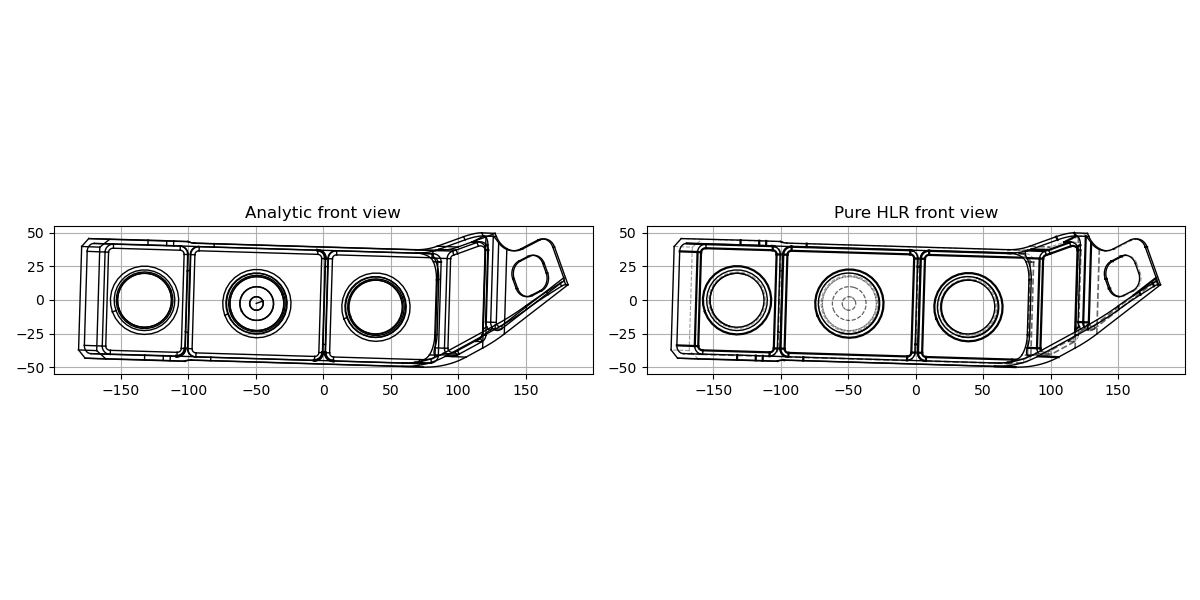

In [3]:
import matplotlib.pyplot as plt
from afr3d.views.plotting import build_hlr_projection_ax2, draw_analytic_view_edges, draw_hlr_compound
# 1. Получаем чистый HLR для того же Ax2, что у аналитического вида
hlr_projection, ax2_hlr = build_hlr_projection_ax2(shape, front_view.ax2)

vis      = hlr_projection["visible"]
hid      = hlr_projection["hidden"]
out_vis  = hlr_projection["outline_visible"]
out_hid  = hlr_projection["outline_hidden"]

# 2. Два subplot'а: слева — analytic, справа — HLR
fig, (ax_ana, ax_hlr) = plt.subplots(1, 2, figsize=(12, 6))
ax_ana.set_aspect("equal", "box")
ax_hlr.set_aspect("equal", "box")

# слева — аналитический вид (только видимые + силуэтные, скрытые тоже можно включить)
draw_analytic_view_edges(
    front_view,
    show_visible=True,
    show_silhouette=True,
    show_hidden=True,        # можно False, если хочешь без штриховки
    fig_ax=(fig, ax_ana),
    title="Analytic front view",
)

# справа — натуральный HLR
# порядок: сначала скрытое, потом видимое, чтобы видимое легло сверху
draw_hlr_compound(ax_hlr, out_hid, color="black", linestyle="--", linewidth=1.2, alpha=0.6)
draw_hlr_compound(ax_hlr, hid,      color="black", linestyle="--", linewidth=0.8, alpha=0.4)
draw_hlr_compound(ax_hlr, out_vis,  color="black", linestyle="-",  linewidth=1.6, alpha=1.0)
draw_hlr_compound(ax_hlr, vis,      color="black", linestyle="-",  linewidth=1.0, alpha=1.0)

ax_hlr.grid(True)
ax_hlr.set_title("Pure HLR front view")

plt.tight_layout()
plt.show()

# новая схема

In [40]:
# В plotting.py
import math

from afr3d.views.analytic import AnalyticView2D, DraftEdge2D, project_point_to_view_2d
from afr3d.views.plotting import sample_hlr_edge_2d

from OCC.Core.TopExp import TopExp_Explorer
from OCC.Core.TopAbs import TopAbs_EDGE


def _point_segment_sqdist(px, py, x1, y1, x2, y2) -> float:
    """
    Квадрат расстояния от точки (px,py) до отрезка [ (x1,y1) - (x2,y2) ].
    """
    vx = x2 - x1
    vy = y2 - y1
    wx = px - x1
    wy = py - y1

    c1 = vx * wx + vy * wy
    if c1 <= 0.0:
        # ближе к p1
        dx = px - x1
        dy = py - y1
        return dx * dx + dy * dy

    c2 = vx * vx + vy * vy
    if c2 <= c1:
        # ближе к p2
        dx = px - x2
        dy = py - y2
        return dx * dx + dy * dy

    t = c1 / c2
    projx = x1 + t * vx
    projy = y1 + t * vy
    dx = px - projx
    dy = py - projy
    return dx * dx + dy * dy


def _polyline_segments(pts_2d):
    """
    Разбивает полилинию pts_2d на сегменты [(x1,y1,x2,y2), ...].
    """
    if len(pts_2d) < 2:
        return []
    segments = []
    for (x1, y1), (x2, y2) in zip(pts_2d[:-1], pts_2d[1:]):
        segments.append((x1, y1, x2, y2))
    return segments


def build_hlr_segment_sets(
    projection,
    *,
    n_samples: int = 64,
):
    """
    Из HLR-проекции строит два набора отрезков:
      - visible_segments
      - hidden_segments
    Каждый — список сегментов (x1, y1, x2, y2) в координатах HLR/вида.
    """
    visible_segments = []
    hidden_segments = []

    def _collect(compound, target_list):
        if compound is None or compound.IsNull():
            return
        exp = TopExp_Explorer(compound, TopAbs_EDGE)
        while exp.More():
            edge = exp.Current()
            exp.Next()
            pts = sample_hlr_edge_2d(edge, n_samples=n_samples)
            segs = _polyline_segments(pts)
            target_list.extend(segs)

    # считаем видимыми и контур-видимыми
    _collect(projection["visible"], visible_segments)
    _collect(projection.get("outline_visible"), visible_segments)

    # скрытые и контур-скрытые
    _collect(projection["hidden"], hidden_segments)
    _collect(projection.get("outline_hidden"), hidden_segments)

    return visible_segments, hidden_segments


from collections import defaultdict
from OCC.Core.TopExp import TopExp_Explorer
from OCC.Core.TopAbs import TopAbs_EDGE

def _collect_hlr_samples(projection, n_samples=32):
    """
    Готовим "обучающую выборку" из HLR:
    для каждого семпла знаем (x, y, klass),
    где klass ∈ {'vis', 'hid', 'vis_outline', 'hid_outline'}.
    """
    samples = []

    def add_compound(compound, klass):
        if compound is None or compound.IsNull():
            return
        exp = TopExp_Explorer(compound, TopAbs_EDGE)
        while exp.More():
            edge = exp.Current()
            exp.Next()
            pts = sample_hlr_edge_2d(edge, n_samples=n_samples)
            for (x, y) in pts:
                samples.append((x, y, klass))

    add_compound(projection["visible"],         "vis")
    add_compound(projection["hidden"],          "hid")
    add_compound(projection["outline_visible"], "vis_outline")
    add_compound(projection["outline_hidden"],  "hid_outline")

    return samples


def refine_analytic_visibility_with_hlr(
    view: AnalyticView2D,
    projection,
    *,
    n_edge_samples: int = 32,
    tol_factor: float = 1e-3,
    mixed_silhouette_min_frac: float = 0.25,
):
    """
    Переписываем visibility/line_style у всех рёбер view по HLR.

    - HLR и аналитический вид уже в одной системе координат (gp_Ax2).
    - Не используем z-buffer для рёбер вообще, только HLR.
    """
    # 1. Собираем bbox вида, чтобы оценить диагональ
    xs = []
    ys = []
    for e in view.edges.values():
        for (x, y) in e.points:
            xs.append(x)
            ys.append(y)
    if not xs:
        return

    x_min, x_max = min(xs), max(xs)
    y_min, y_max = min(ys), max(ys)
    dx = x_max - x_min
    dy = y_max - y_min
    diag = (dx * dx + dy * dy) ** 0.5
    if diag <= 0:
        diag = 1.0

    tol_sq_base = (tol_factor * diag) ** 2

    # 2. Семплы из HLR
    hlr_samples = _collect_hlr_samples(projection, n_samples=n_edge_samples)
    if not hlr_samples:
        return

    # Можно ускорять (k-d дерево и т.п.), но для начала — тупо O(N*M).

    # 3. Для каждого ребра считаем статистику по ближайшим HLR-точкам
    for e in view.edges.values():
        # сбрасываем старую видимость и line_style
        e.visibility = "unknown"
        e.line_style = "default"

        if len(e.points) < 2:
            continue

        counts = defaultdict(int)

        for (px, py) in e.points:
            best_dist_sq = None
            best_klass = None

            for (hx, hy, klass) in hlr_samples:
                dx = hx - px
                dy = hy - py
                d2 = dx * dx + dy * dy
                if best_dist_sq is None or d2 < best_dist_sq:
                    best_dist_sq = d2
                    best_klass = klass

            if best_dist_sq is None or best_dist_sq > tol_sq_base:
                # семпл не "прилип" ни к одной HLR-линии
                continue

            counts[best_klass] += 1

        total_hits = sum(counts.values())
        if total_hits == 0:
            # fallback: ничего не нашли — считаем видимым (или используем z-buffer по граням)
            # TODO: можно аккуратно использовать face_visibility при желании
            e.visibility = "visible"
            e.line_style = "solid"
            continue

        vis     = counts["vis"] + counts["vis_outline"]
        hid     = counts["hid"] + counts["hid_outline"]
        outline = counts["vis_outline"] + counts["hid_outline"]

        frac_vis = vis / total_hits
        frac_hid = hid / total_hits
        frac_outline = outline / total_hits

        # 4. Классификация
        #   - чисто видимый / чисто скрытый
        #   - смешанный: если outline-доля заметна → silhouette, иначе берём мажоритарный класс
        if frac_vis >= 0.9:
            e.visibility = "visible"
            e.line_style = "solid"
        elif frac_hid >= 0.9:
            e.visibility = "hidden"
            e.line_style = "hidden"
        else:
            # Смесь. Решаем, считать ли это силуэтом.
            if frac_outline >= mixed_silhouette_min_frac and frac_vis > 0 and frac_hid > 0:
                e.visibility = "silhouette"
                e.line_style = "solid_thick"
            else:
                # берём сторону с большим весом
                if frac_vis >= frac_hid:
                    e.visibility = "visible"
                    e.line_style = "solid"
                else:
                    e.visibility = "hidden"
                    e.line_style = "hidden"

    # 5. Пересчёт видимости вершин:
    for v in view.vertices.values():
        v.visible = any(
            view.edges[e_idx].visibility in ("visible", "silhouette")
            for e_idx in v.incident_edges
            if e_idx in view.edges
        )

In [30]:
from collections import Counter
def debug_edge_visibility_stats(view: AnalyticView2D) -> None:
    """
    Печатает статистику по видимости рёбер на виде.
    """
    cnt = Counter(e.visibility for e in view.edges.values())
    total = sum(cnt.values()) or 1

    print(f"[EDGE VIS STATS] view='{view.view_name}', total_edges={total}")
    for state in ("visible", "silhouette", "hidden", "unknown"):
        n = cnt.get(state, 0)
        print(f"  {state:10s}: {n:5d} ({n / total:6.1%})")

In [41]:
from afr3d.views.analytic import (
    build_topology_maps, collect_projected_vertices,
    collect_projected_edges, assign_visibility_to_edges_and_vertices,
    collect_face_infos
)
from typing import Dict, List, Tuple, Optional, Set, Literal
from OCC.Core.TopoDS import (
    TopoDS_Shape
)
from OCC.Core.gp import gp_Pnt, gp_Vec, gp_Ax2

def build_analytic_view_2d(
    shape: TopoDS_Shape,
    view_ax2: gp_Ax2,
    view_name: str = "front",
    face_visibility: Optional["FaceVisibilityResult"] = None,
    *,
    n_edge_samples: int = 32,
) -> AnalyticView2D:
    """
    Строит полный аналитический вид (AnalyticView2D) для одного направления вида.

    Параметры
    ---------
    shape:
        исходный TopoDS_Shape
    view_ax2:
        gp_Ax2, задающая систему координат вида (как для HLR)
    view_name:
        имя вида ("front", "top", "side", "section_A", ...)
    face_visibility:
        результат compute_face_visibility_by_zbuffer для ЭТОГО вида.
        Если None, то visibility рёбер/вершин остаётся 'unknown'/False.
    n_edge_samples:
        количество точек дискретизации на кривой ребра (для полилинии).

    Возвращает
    ----------
    AnalyticView2D
    """
    # 1. Топология: карты и инцидентность
    vertex_map, edge_map, face_map, edge_to_vertices, edge_to_faces = build_topology_maps(shape)

    # 2. Проекция вершин и рёбер
    proj_vertices = collect_projected_vertices(vertex_map, view_ax2)
    proj_edges = collect_projected_edges(
        edge_map=edge_map,
        edge_to_vertices=edge_to_vertices,
        edge_to_faces=edge_to_faces,
        view_ax2=view_ax2,
        n_samples=n_edge_samples,
    )

    # 3. Видимость по граням (z-buffer)
    if face_visibility is not None:
        assign_visibility_to_edges_and_vertices(
            proj_edges, proj_vertices, face_visibility=face_visibility
        )

    # 3b. Информация по граням (работает и при face_visibility=None)
    face_infos = collect_face_infos(face_map, face_visibility)

    # 4. Собираем AnalyticView2D
    view = AnalyticView2D(
        view_name=view_name,
        ax2=view_ax2,
        vertex_map=vertex_map,
        edge_map=edge_map,
        face_map=face_map,
        vertices=proj_vertices,
        edges=proj_edges,
        faces=face_infos,
    )

    # заполняем surface_types
    for e in proj_edges.values():
        e.surface_types = [
            view.faces[fi].surface_type
            for fi in e.face_indices
            if fi in view.faces
        ]

    return view

In [42]:
from afr3d.views.orientation import make_default_front_top_side_ax2
from afr3d.views.plotting import build_hlr_projection_ax2

axes_map = make_default_front_top_side_ax2(shape)
front_ax2 = axes_map["front"]

# 1. HLR и аналитика в одной Ax2
projection, _ = build_hlr_projection_ax2(shape, front_ax2)
front_view = build_analytic_view_2d(
    shape,
    view_ax2=front_ax2,
    view_name="front",
    face_visibility=None,    # НЕ используем z-buffer
    n_edge_samples=64,
)

# 2. Уточняем видимость рёбер по HLR
refine_analytic_visibility_with_hlr(front_view, projection)

# 3. Смотрим статистику
debug_edge_visibility_stats(front_view)

[EDGE VIS STATS] view='front', total_edges=393
  visible   :   267 ( 67.9%)
  silhouette:    17 (  4.3%)
  hidden    :   109 ( 27.7%)
  unknown   :     0 (  0.0%)


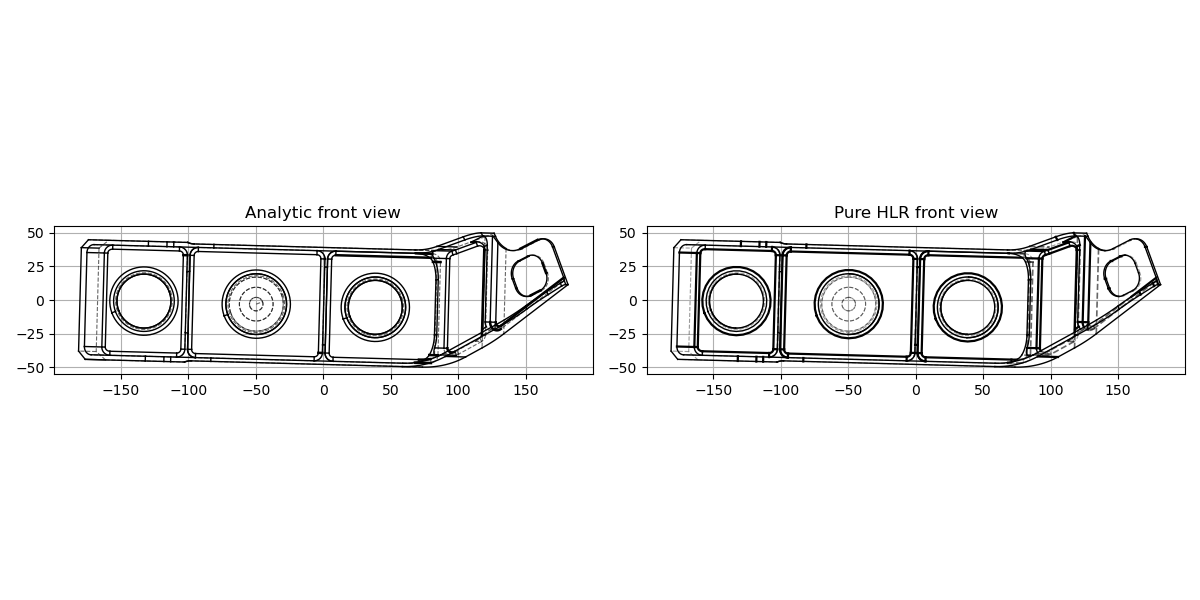

In [43]:
import matplotlib.pyplot as plt
from afr3d.views.plotting import draw_analytic_view_edges, draw_hlr_compound

vis      = projection["visible"]
hid      = projection["hidden"]
out_vis  = projection["outline_visible"]
out_hid  = projection["outline_hidden"]

# 2. Два subplot'а: слева — analytic, справа — HLR
fig, (ax_ana, ax_hlr) = plt.subplots(1, 2, figsize=(12, 6))
ax_ana.set_aspect("equal", "box")
ax_hlr.set_aspect("equal", "box")

# слева — аналитический вид (только видимые + силуэтные, скрытые тоже можно включить)
draw_analytic_view_edges(
    front_view,
    show_visible=True,
    show_silhouette=True,
    show_hidden=True,        # можно False, если хочешь без штриховки
    fig_ax=(fig, ax_ana),
    title="Analytic front view",
)

# справа — натуральный HLR
# порядок: сначала скрытое, потом видимое, чтобы видимое легло сверху
draw_hlr_compound(ax_hlr, out_hid, color="black", linestyle="--", linewidth=1.2, alpha=0.6)
draw_hlr_compound(ax_hlr, hid,      color="black", linestyle="--", linewidth=0.8, alpha=0.4)
draw_hlr_compound(ax_hlr, out_vis,  color="black", linestyle="-",  linewidth=1.6, alpha=1.0)
draw_hlr_compound(ax_hlr, vis,      color="black", linestyle="-",  linewidth=1.0, alpha=1.0)

ax_hlr.grid(True)
ax_hlr.set_title("Pure HLR front view")

plt.tight_layout()
plt.show()

In [71]:
side_ax2 = axes_map["side"]

# 1. HLR и аналитика в одной Ax2
side_projection, _ = build_hlr_projection_ax2(shape, side_ax2)
side_view = build_analytic_view_2d(
    shape,
    view_ax2=side_ax2,
    view_name="side",
    face_visibility=None,
    n_edge_samples=64,
)

# 2. Уточняем видимость рёбер по HLR
refine_analytic_visibility_with_hlr(side_view, side_projection)

# 3. Смотрим статистику
debug_edge_visibility_stats(side_view)

[EDGE VIS STATS] view='side', total_edges=393
  visible   :    55 ( 14.0%)
  silhouette:    10 (  2.5%)
  hidden    :   328 ( 83.5%)
  unknown   :     0 (  0.0%)


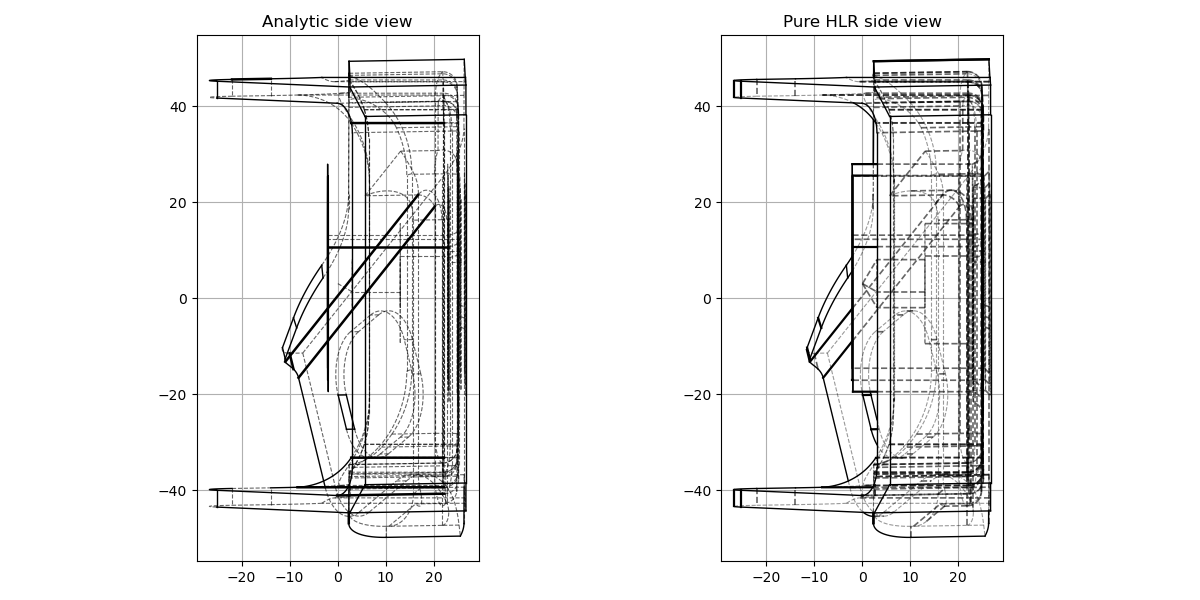

In [72]:
vis      = side_projection["visible"]
hid      = side_projection["hidden"]
out_vis  = side_projection["outline_visible"]
out_hid  = side_projection["outline_hidden"]

# 2. Два subplot'а: слева — analytic, справа — HLR
fig, (ax_ana, ax_hlr) = plt.subplots(1, 2, figsize=(12, 6))
ax_ana.set_aspect("equal", "box")
ax_hlr.set_aspect("equal", "box")

# слева — аналитический вид (только видимые + силуэтные, скрытые тоже можно включить)
draw_analytic_view_edges(
    side_view,
    show_visible=True,
    show_silhouette=True,
    show_hidden=True,        # можно False, если хочешь без штриховки
    fig_ax=(fig, ax_ana),
    title="Analytic side view",
)

# справа — натуральный HLR
# порядок: сначала скрытое, потом видимое, чтобы видимое легло сверху
draw_hlr_compound(ax_hlr, out_hid, color="black", linestyle="--", linewidth=1.2, alpha=0.6)
draw_hlr_compound(ax_hlr, hid,      color="black", linestyle="--", linewidth=0.8, alpha=0.4)
draw_hlr_compound(ax_hlr, out_vis,  color="black", linestyle="-",  linewidth=1.6, alpha=1.0)
draw_hlr_compound(ax_hlr, vis,      color="black", linestyle="-",  linewidth=1.0, alpha=1.0)

ax_hlr.grid(True)
ax_hlr.set_title("Pure HLR side view")

plt.tight_layout()
plt.show()

# Модифицируем вид HLR

In [ ]:
from OCC.Core.gp import gp_Pnt, gp_Dir, gp_Ax2
from OCC.Core.HLRAlgo import HLRAlgo_Projector
from OCC.Core.HLRBRep import HLRBRep_Algo, HLRBRep_HLRToShape
from OCC.Core.TopExp import TopExp_Explorer
from OCC.Core.TopAbs import TopAbs_EDGE

from OCC.Core.GeomAbs import (
    GeomAbs_Line,
    GeomAbs_Circle,
    GeomAbs_Ellipse,
    GeomAbs_BSplineCurve,
    GeomAbs_BezierCurve,
    GeomAbs_OtherCurve,
)
from OCC.Core.TopoDS import (
    TopoDS_Shape,
    TopoDS_Face,
    TopoDS_Edge,
    TopoDS_Vertex,
    topods
)
from OCC.Core.BRepAdaptor import BRepAdaptor_Curve
from OCC.Core.BRep import BRep_Builder
from OCC.Core.TopoDS import TopoDS_Compound

def _union_compounds(shapes):
    builder = BRep_Builder()
    comp = TopoDS_Compound()
    builder.MakeCompound(comp)
    has_any = False
    for shp in shapes:
        if shp is None:
            continue
        if shp.IsNull():
            continue
        builder.Add(comp, shp)
        has_any = True
    return comp if has_any else None

def build_hlr_projection_ax2(shape: TopoDS_Shape, view_ax2: gp_Ax2):
    algo = HLRBRep_Algo()
    algo.Add(shape)

    projector = HLRAlgo_Projector(view_ax2)
    algo.Projector(projector)
    algo.Update()
    algo.Hide()

    hlr_to_shape = HLRBRep_HLRToShape(algo)

    visible = hlr_to_shape.VCompound()
    hidden  = hlr_to_shape.HCompound()

    # гладкие ребра
    try:
        rg1_v = hlr_to_shape.Rg1LineVCompound()
    except Exception:
        rg1_v = None
    try:
        rg1_h = hlr_to_shape.Rg1LineHCompound()
    except Exception:
        rg1_h = None

    # C2 (опционально)
    try:
        rgn_v = hlr_to_shape.RgNLineVCompound()
    except Exception:
        rgn_v = None
    try:
        rgn_h = hlr_to_shape.RgNLineHCompound()
    except Exception:
        rgn_h = None

    # контуры
    try:
        out_v = hlr_to_shape.OutLineVCompound()
    except Exception:
        out_v = None
    try:
        out_h = hlr_to_shape.OutLineHCompound()
    except Exception:
        out_h = None

    outline_visible = _union_compounds([rg1_v, rgn_v, out_v])
    outline_hidden  = _union_compounds([rg1_h, rgn_h, out_h])

    projection = {
        "visible":         visible,
        "hidden":          hidden,
        "outline_visible": outline_visible,
        "outline_hidden":  outline_hidden,
    }
    return projection, view_ax2

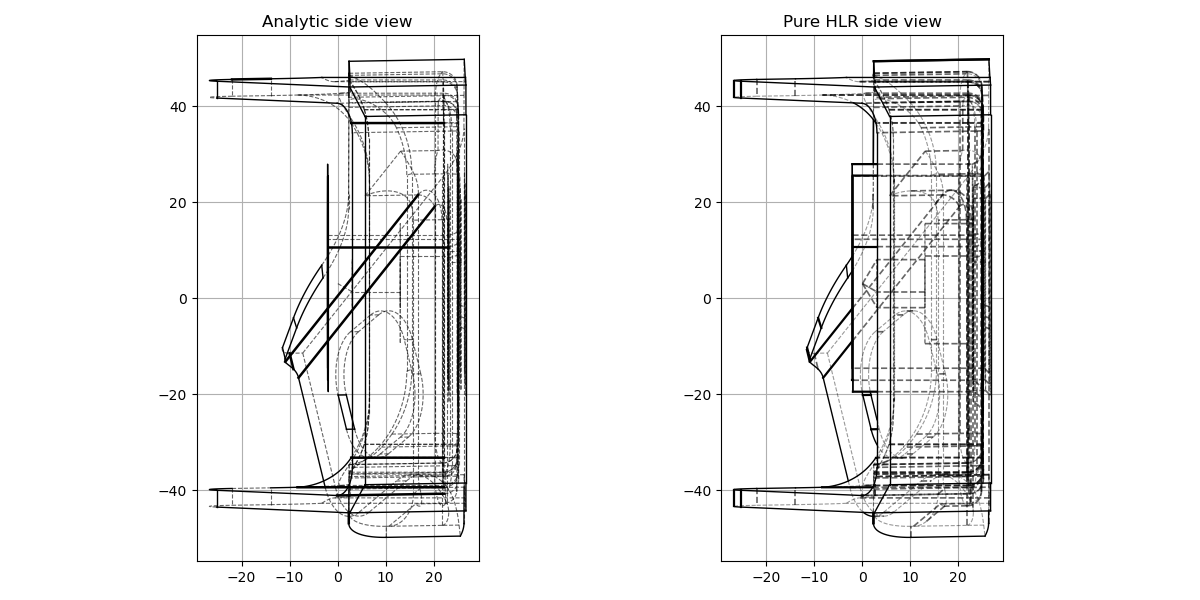

In [66]:
side_projection, _ = build_hlr_projection_ax2(shape, side_ax2)
side_view = build_analytic_view_2d(
    shape,
    view_ax2=side_ax2,
    view_name="side",
    face_visibility=None,
    n_edge_samples=64,
)

refine_analytic_visibility_with_hlr(side_view, side_projection)

vis      = side_projection["visible"]
hid      = side_projection["hidden"]
out_vis  = side_projection["outline_visible"]
out_hid  = side_projection["outline_hidden"]

# 2. Два subplot'а: слева — analytic, справа — HLR
fig, (ax_ana, ax_hlr) = plt.subplots(1, 2, figsize=(12, 6))
ax_ana.set_aspect("equal", "box")
ax_hlr.set_aspect("equal", "box")

# слева — аналитический вид (только видимые + силуэтные, скрытые тоже можно включить)
draw_analytic_view_edges(
    side_view,
    show_visible=True,
    show_silhouette=True,
    show_hidden=True,        # можно False, если хочешь без штриховки
    fig_ax=(fig, ax_ana),
    title="Analytic side view",
)

# справа — натуральный HLR
# порядок: сначала скрытое, потом видимое, чтобы видимое легло сверху
draw_hlr_compound(ax_hlr, out_hid, color="black", linestyle="--", linewidth=1.2, alpha=0.6)
draw_hlr_compound(ax_hlr, hid,      color="black", linestyle="--", linewidth=0.8, alpha=0.4)
draw_hlr_compound(ax_hlr, out_vis,  color="black", linestyle="-",  linewidth=1.6, alpha=1.0)
draw_hlr_compound(ax_hlr, vis,      color="black", linestyle="-",  linewidth=1.0, alpha=1.0)

ax_hlr.grid(True)
ax_hlr.set_title("Pure HLR side view")

plt.tight_layout()
plt.show()

# новые фунции для резки рёбер аналитических

In [ ]:
from dataclasses import dataclass
# для целей отрисовки и HLR-совместимости мы строим отдельный список сегментов 
@dataclass
class DraftEdgeSegment2D:
    """
    Отрезок (сегмент) одного аналитического ребра, уже
    классифицированный по видимости на основе HLR.

    parent_edge_index:
        индекс исходного DraftEdge2D
    points:
        точки полилинии этого сегмента (подмассив от DraftEdge2D.points)
    visibility:
        'visible', 'hidden', 'silhouette'
    line_style:
        'solid', 'hidden', 'solid_thick', ...
    """
    parent_edge_index: int
    points: List[Tuple[float, float]]
    visibility: str
    line_style: str

def _collect_hlr_samples(
    projection: Dict[str, TopoDS_Shape],
    n_samples: int = 32,
) -> List[Tuple[float, float, str]]:
    """
    Строит плоское облако точек HLR с метками:

        'vis'          — видимая внутренняя линия
        'hid'          — скрытая внутренняя линия
        'vis_outline'  — видимый контур (outline)
        'hid_outline'  — скрытый контур (outline)

    Координаты уже в плоскости вида (совпадают с аналитическим видом).
    """
    pts: List[Tuple[float, float, str]] = []

    type_map = [
        ("visible",         "vis"),
        ("hidden",          "hid"),
        ("outline_visible", "vis_outline"),
        ("outline_hidden",  "hid_outline"),
    ]

    for key, label in type_map:
        comp = projection.get(key)
        if comp is None or comp.IsNull():
            continue

        exp = TopExp_Explorer(comp, TopAbs_EDGE)
        while exp.More():
            edge = exp.Current()
            exp.Next()

            edge_pts = sample_hlr_edge_2d(edge, n_samples=n_samples)
            for x, y in edge_pts:
                pts.append((x, y, label))

    return pts


def classify_edge_samples_by_hlr(
    view: AnalyticView2D,
    projection: Dict[str, TopoDS_Shape],
    *,
    n_samples_hlr: int = 32,
    tol_factor: float = 1e-3,
) -> Dict[int, List[str]]:
    """
    Возвращает labels_per_edge:
        edge_index -> [label_0, ..., label_{n-1}]

    label_i ∈ {'vis', 'hid', 'vis_outline', 'hid_outline'}.
    'none' используется ТОЛЬКО если HLR вообще не дал ни одной точки.
    """
    hlr_pts = _collect_hlr_samples(projection, n_samples=n_samples_hlr)

    labels_per_edge: Dict[int, List[str]] = {}

    if not hlr_pts:
        # HLR пустой — всё помечаем как none
        for e_idx, e in view.edges.items():
            labels_per_edge[e_idx] = ["none"] * len(e.points)
        return labels_per_edge

    # --- масштаб по bbox (аналитический вид + HLR) ---
    xs = [p[0] for p in hlr_pts]
    ys = [p[1] for p in hlr_pts]
    for e in view.edges.values():
        for (x, y) in e.points:
            xs.append(x)
            ys.append(y)

    x_min, x_max = min(xs), max(xs)
    y_min, y_max = min(ys), max(ys)
    dx = x_max - x_min
    dy = y_max - y_min
    diag = math.hypot(dx, dy) or 1.0

    tol = tol_factor * diag
    tol2 = tol * tol

    for e_idx, e in view.edges.items():
        pts = e.points
        if not pts:
            labels_per_edge[e_idx] = []
            continue

        labels: List[str] = []

        for (x, y) in pts:
            best_label = None
            best_d2 = None

            # ищем ближайший HLR-семпл
            for (hx, hy, hlabel) in hlr_pts:
                dx = x - hx
                dy = y - hy
                d2 = dx * dx + dy * dy
                if best_d2 is None or d2 < best_d2:
                    best_d2 = d2
                    best_label = hlabel

            # ВАЖНО:
            #  - если даже ближайшая точка далеко, всё равно используем её метку:
            #    это лучше, чем 'none', который рвёт сегменты.
            #  - tol оставляем только на случай HLR-артефактов, если хочешь —
            #    можно добавить второй порог и при best_d2 >> tol2 считать 'vis'.
            if best_label is None:
                labels.append("vis")  # fallback
            else:
                labels.append(best_label)

        labels_per_edge[e_idx] = labels

    return labels_per_edge



def build_edge_segments_from_labels(
    view: AnalyticView2D,
    labels_per_edge: Dict[int, List[str]],
    *,
    min_run: int = 3,
) -> List[DraftEdgeSegment2D]:
    """
    Строит сегменты рёбер по меткам HLR с простым сглаживанием.

    min_run:
        минимальное количество подряд идущих точек с новым классом,
        чтобы начать новый сегмент. Короткие "островки" считаем шумом.
    """
    segments: List[DraftEdgeSegment2D] = []

    def label_to_vis_style(lbl: str) -> Optional[Tuple[str, str]]:
        if lbl == "vis":
            return "visible", "solid"
        if lbl == "hid":
            return "hidden", "hidden"
        if lbl == "vis_outline":
            return "silhouette", "solid_thick"
        if lbl == "hid_outline":
            return "hidden", "hidden"
        return None  # 'none' и прочие

    for e_idx, e in view.edges.items():
        pts = e.points
        if len(pts) < 2:
            continue

        labels = labels_per_edge.get(e_idx)
        if not labels or len(labels) != len(pts):
            continue

        # --- предварительное сглаживание по run-length ---
        # превращаем labels в "чистую" последовательность с фильтрацией коротких островков
        cleaned = labels.copy()

        # 1) 'none' заменяем на соседний класс, если оба соседа совпадают
        n = len(cleaned)
        for i in range(1, n - 1):
            if cleaned[i] == "none":
                if cleaned[i - 1] == cleaned[i + 1] and cleaned[i - 1] != "none":
                    cleaned[i] = cleaned[i - 1]

        # 2) run-length сглаживание: короткие островки < min_run затираем
        i = 0
        while i < n:
            lbl = cleaned[i]
            j = i + 1
            while j < n and cleaned[j] == lbl:
                j += 1
            run_len = j - i
            if lbl != "none" and run_len < min_run:
                # если по краям один и тот же нормальный класс — перекрашиваем в него
                left = cleaned[i - 1] if i - 1 >= 0 else None
                right = cleaned[j] if j < n else None
                if left is not None and left == right and left != "none":
                    for k in range(i, j):
                        cleaned[k] = left
            i = j

        # --- теперь строим сегменты по cleaned ---
        current_lbl = None
        current_vis = None
        current_style = None
        start_idx = 0

        for idx in range(n):
            lbl = cleaned[idx]
            vs = label_to_vis_style(lbl)

            if vs is None:
                # нет валидного класса — не рвём жёстко, просто завершаем сегмент, если он был
                if current_vis is not None and idx - start_idx >= 2:
                    seg_points = pts[start_idx:idx]
                    segments.append(
                        DraftEdgeSegment2D(
                            parent_edge_index=e_idx,
                            points=seg_points,
                            visibility=current_vis,
                            line_style=current_style,
                        )
                    )
                current_lbl = None
                current_vis = None
                current_style = None
                start_idx = idx + 1
                continue

            vis, style = vs

            if current_lbl is None:
                current_lbl = lbl
                current_vis = vis
                current_style = style
                start_idx = idx
            elif lbl != current_lbl:
                # смена класса — закрываем предыдущий сегмент
                if current_vis is not None and idx - start_idx >= 2:
                    seg_points = pts[start_idx:idx]
                    segments.append(
                        DraftEdgeSegment2D(
                            parent_edge_index=e_idx,
                            points=seg_points,
                            visibility=current_vis,
                            line_style=current_style,
                        )
                    )
                current_lbl = lbl
                current_vis = vis
                current_style = style
                start_idx = idx

        # хвост
        if current_vis is not None and n - start_idx >= 2:
            seg_points = pts[start_idx:n]
            segments.append(
                DraftEdgeSegment2D(
                    parent_edge_index=e_idx,
                    points=seg_points,
                    visibility=current_vis,
                    line_style=current_style,
                )
            )

    return segments

In [64]:
# в plotting.py простой рендер для DraftEdgeSegment2D
def draw_edge_segments(
    segments: List[DraftEdgeSegment2D],
    *,
    fig_ax=None,
    title: Optional[str] = None,
):
    """
    Рисуем список сегментов (после классификации через HLR).

    visibility / line_style используются так же, как для рёбер.
    """
    if fig_ax is None:
        fig, ax = plt.subplots(figsize=(8, 6))
    else:
        fig, ax = fig_ax

    ax.set_aspect("equal", "box")

    for seg in segments:
        pts = seg.points
        if len(pts) < 2:
            continue
        xs = [p[0] for p in pts]
        ys = [p[1] for p in pts]

        style = seg.line_style
        if style == "solid":
            ls = "-"
            lw = 1.0
            alpha = 1.0
        elif style == "solid_thick":
            ls = "-"
            lw = 1.8
            alpha = 1.0
        elif style == "hidden":
            ls = "--"
            lw = 0.8
            alpha = 0.6
        else:
            ls = "-"
            lw = 0.8
            alpha = 0.7

        ax.plot(xs, ys, linestyle=ls, linewidth=lw, alpha=alpha, color="black")

    ax.grid(True)
    if title is None:
        title = "Analytic segments (HLR-refined)"
    ax.set_title(title)
    return fig, ax


def build_outline_segments_from_hlr(
    projection: Dict[str, TopoDS_Shape],
    *,
    n_samples: int = 64,
) -> List[DraftEdgeSegment2D]:
    """
    Строит сегменты только по HLR-линиям, которые могут не иметь
    соответствующих BRep-ребер (силуэты, контуры и т.п.).

    Возвращает список DraftEdgeSegment2D с parent_edge_index = -1.
    """
    segments: List[DraftEdgeSegment2D] = []

    def add_from_compound(comp: Optional[TopoDS_Shape], visibility: str, line_style: str):
        if comp is None or comp.IsNull():
            return
        exp = TopExp_Explorer(comp, TopAbs_EDGE)
        while exp.More():
            edge = exp.Current()
            exp.Next()

            pts = sample_hlr_edge_2d(edge, n_samples=n_samples)
            if len(pts) < 2:
                continue

            seg = DraftEdgeSegment2D(
                parent_edge_index=-1,   # нет исходного DraftEdge2D
                points=pts,
                visibility=visibility,
                line_style=line_style,
            )
            segments.append(seg)

    # контуры / силуэты
    outline_vis = projection.get("outline_visible")
    outline_hid = projection.get("outline_hidden")

    # видимые силуэты/контуры — как silhouette или просто видимые толстые линии
    add_from_compound(outline_vis, visibility="silhouette", line_style="solid_thick")

    # скрытые силуэты/контуры — как штриховые
    add_from_compound(outline_hid, visibility="hidden", line_style="hidden")

    return segments


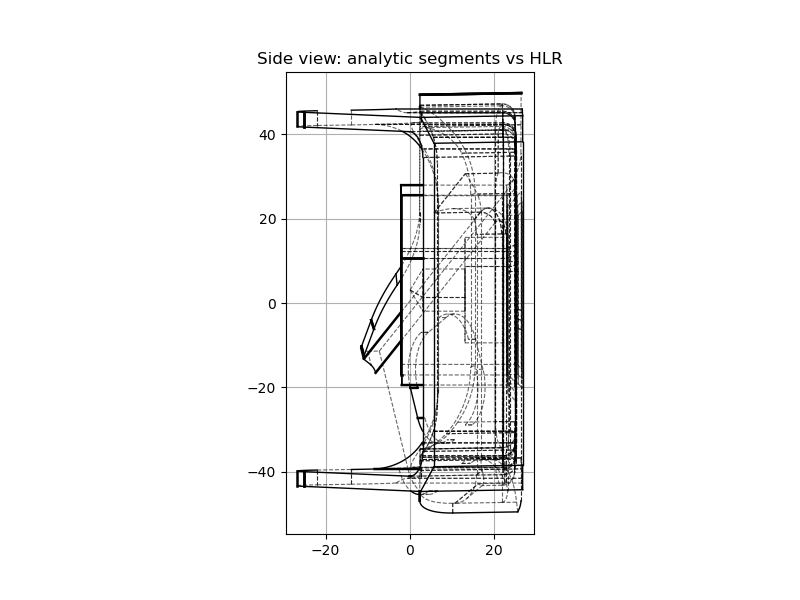

In [74]:
from afr3d.views.visibility import compute_face_visibility_by_zbuffer

projection_new, side_ax2 = build_hlr_projection_ax2(shape, side_ax2)

# face_vis = compute_face_visibility_by_zbuffer(shape, side_ax2)
side_view_new = build_analytic_view_2d(
    shape,
    view_ax2=side_ax2,
    view_name="side",
    face_visibility=None,
    n_edge_samples=64,   # плотность семплов аналитического ребра
)

# 2. Классифицируем точки рёбер по HLR
labels_per_edge = classify_edge_samples_by_hlr(
    side_view_new,
    projection_new,
    n_samples_hlr=64,     # плотность семплов HLR-линий
    tol_factor=1e-3,      # можно поджать при необходимости
)

# 3. Нарезаем сегменты
edge_segments = build_edge_segments_from_labels(side_view_new, labels_per_edge)
outline_segments = build_outline_segments_from_hlr(projection_new, n_samples=64)
segments = edge_segments + outline_segments

# 4. Смотрим, как это выглядит
fig, ax = draw_edge_segments(segments, title="Side view: analytic segments vs HLR")
plt.show()

In [68]:
import math

def _polyline_length(pts):
    if len(pts) < 2:
        return 0.0
    acc = 0.0
    for (x1, y1), (x2, y2) in zip(pts[:-1], pts[1:]):
        dx = x2 - x1
        dy = y2 - y1
        acc += math.hypot(dx, dy)
    return acc

In [70]:
from collections import defaultdict
from typing import Dict, List, Tuple

from afr3d.views.analytic import AnalyticView2D, DraftEdge2D

def debug_edge_segment_coverage(
    view: AnalyticView2D,
    segments: List[DraftEdgeSegment2D],
    *,
    length_tol_abs: float = 1e-6,
    length_tol_rel: float = 0.1,
) -> Dict[int, Dict[str, float]]:
    """
    Диагностирует, какие рёбра "потеряли" длину при переходе к сегментам.

    Возвращает словарь:
      edge_index -> {
          'edge_len': L_edge,
          'seg_len':  L_segments_sum,
          'coverage': seg_len / (edge_len + eps),
      }

    И печатает подозрительные рёбра:
      - coverage ≈ 0 (сегментов нет вообще)
      - coverage << 1 (например, < (1 - length_tol_rel))
    """
    # 1. суммарная длина сегментов по родительскому ребру
    seg_len_by_edge: Dict[int, float] = defaultdict(float)
    for seg in segments:
        if seg.parent_edge_index is None or seg.parent_edge_index < 0:
            # HLR-only сегменты, их игнорируем здесь
            continue
        seg_len_by_edge[seg.parent_edge_index] += _polyline_length(seg.points)

    # 2. длина исходных рёбер
    coverage_info: Dict[int, Dict[str, float]] = {}
    print("[DEBUG] Edge coverage by segments:")

    for e_idx, e in view.edges.items():
        L_edge = _polyline_length(e.points)
        L_seg = seg_len_by_edge.get(e_idx, 0.0)
        if L_edge <= length_tol_abs:
            coverage = 1.0
        else:
            coverage = L_seg / (L_edge + 1e-12)

        coverage_info[e_idx] = {
            "edge_len": L_edge,
            "seg_len": L_seg,
            "coverage": coverage,
        }

        # печатаем подозрительные случаи
        if L_edge > length_tol_abs:
            if L_seg <= length_tol_abs:
                print(
                    f"  Edge {e_idx:4d}: LOST ENTIRELY, "
                    f"L_edge={L_edge:.4g}, L_seg={L_seg:.4g}, "
                    f"vis={getattr(e, 'visibility', None)}"
                )
            elif coverage < (1.0 - length_tol_rel):
                print(
                    f"  Edge {e_idx:4d}: PARTIAL LOSS, "
                    f"coverage={coverage:.3f}, "
                    f"L_edge={L_edge:.4g}, L_seg={L_seg:.4g}, "
                    f"vis={getattr(e, 'visibility', None)}"
                )

    return coverage_info

def snapshot_edge_visibility(view: AnalyticView2D) -> Dict[int, str]:
    """
    Делает снимок текущей видимости рёбер (до переразметки).
    """
    return {idx: e.visibility for idx, e in view.edges.items()}

def debug_edge_visibility_diff(
    view: AnalyticView2D,
    old_visibility: Dict[int, str],
    segments: List[DraftEdgeSegment2D],
):
    """
    Сравнивает старую видимость рёбер (old_visibility)
    с новой, выведенной по сегментам.

    Новая видимость по ребру считается так:
      - если все сегменты visible  -> 'visible'
      - если все hidden            -> 'hidden'
      - если смесь                 -> 'silhouette'
      - если сегментов нет         -> 'lost'
    """
    # 1. группируем сегменты по родительскому ребру
    seg_by_edge: Dict[int, List[DraftEdgeSegment2D]] = defaultdict(list)
    for seg in segments:
        if seg.parent_edge_index is None or seg.parent_edge_index < 0:
            continue
        seg_by_edge[seg.parent_edge_index].append(seg)

    print("[DEBUG] Edge visibility diff (old vs segments-derived):")

    for e_idx, e in view.edges.items():
        old_vis = old_visibility.get(e_idx, "unknown")
        segs = seg_by_edge.get(e_idx, [])

        if not segs:
            new_vis = "lost"
        else:
            vis_states = {s.visibility for s in segs}
            if vis_states == {"visible"}:
                new_vis = "visible"
            elif vis_states == {"hidden"}:
                new_vis = "hidden"
            elif vis_states <= {"visible", "hidden", "silhouette"}:
                if "silhouette" in vis_states or ( "visible" in vis_states and "hidden" in vis_states ):
                    new_vis = "silhouette"
                else:
                    # теоретически не должны сюда попасть
                    new_vis = ",".join(sorted(vis_states))
            else:
                new_vis = ",".join(sorted(vis_states))

        if new_vis != old_vis:
            L_edge = _polyline_length(e.points)
            print(
                f"  Edge {e_idx:4d}: "
                f"old={old_vis:10s} -> new={new_vis:10s} "
                f"(len={L_edge:.4g})"
            )

In [73]:
# до refine / сегментации
old_vis = snapshot_edge_visibility(side_view)

In [91]:
# ... refine_analytic_visibility_with_hlr / build_edge_segments_from_labels ...
coverage_info = debug_edge_segment_coverage(side_view_new, edge_segments)
debug_edge_visibility_diff(side_view_new, old_vis, edge_segments)

[DEBUG] Edge coverage by segments:
  Edge   43: LOST ENTIRELY, L_edge=2.299, L_seg=0, vis=unknown
  Edge   44: LOST ENTIRELY, L_edge=7.107, L_seg=0, vis=unknown
  Edge   58: LOST ENTIRELY, L_edge=7.571, L_seg=0, vis=unknown
  Edge   62: LOST ENTIRELY, L_edge=4.644, L_seg=0, vis=unknown
  Edge   74: LOST ENTIRELY, L_edge=63.65, L_seg=0, vis=unknown
  Edge   81: LOST ENTIRELY, L_edge=19.21, L_seg=0, vis=unknown
  Edge  100: LOST ENTIRELY, L_edge=5.46, L_seg=0, vis=unknown
  Edge  102: LOST ENTIRELY, L_edge=7.335, L_seg=0, vis=unknown
  Edge  104: LOST ENTIRELY, L_edge=5.46, L_seg=0, vis=unknown
  Edge  107: LOST ENTIRELY, L_edge=45.5, L_seg=0, vis=unknown
  Edge  108: LOST ENTIRELY, L_edge=23.53, L_seg=0, vis=unknown
  Edge  110: LOST ENTIRELY, L_edge=10.14, L_seg=0, vis=unknown
  Edge  120: LOST ENTIRELY, L_edge=22.33, L_seg=0, vis=unknown
  Edge  122: LOST ENTIRELY, L_edge=30.5, L_seg=0, vis=unknown
  Edge  131: LOST ENTIRELY, L_edge=6.233, L_seg=0, vis=unknown
  Edge  151: LOST ENTIRE

In [89]:
def draw_hlr_compound_by_type(
    projection: Dict[str, TopoDS_Shape],
    ax,
    *,
    colors: Optional[Dict[str, str]] = None,
    linewidth: float = 1.0,
    alpha: float = 1.0,
    outline_scale: float = 1.5,
    hidden_linestyle: str = "--",
):
    """
    Рисуем все HLR-компаунды (visible / hidden / outline_visible / outline_hidden)
    на один Axes.

    projection:
        dict вида:
            {
              "visible":         TopoDS_Shape,
              "hidden":          TopoDS_Shape,
              "outline_visible": TopoDS_Shape или None,
              "outline_hidden":  TopoDS_Shape или None,
            }

    ax:
        matplotlib Axes.

    colors:
        dict с цветами по ключам projection:
            {
              "visible":         "#000000",
              "hidden":          "#888888",
              "outline_visible": "#0000ff",
              "outline_hidden":  "#8888ff",
            }
        Если None — используются значения по умолчанию.

    linewidth:
        базовая толщина линии для обычных (visible/hidden) линий.

    alpha:
        базовая прозрачность для всех линий (можно переиграть при желании).

    outline_scale:
        во сколько раз outline-линии толще обычных.

    hidden_linestyle:
        стиль линии для скрытых рёбер ("--", "-.", ":" и т.п.).
    """
    if colors is None:
        colors = {
            "visible":         "black",
            "hidden":          "0.5",      # серый
            "outline_visible": "blue",
            "outline_hidden":  "0.6",      # светло-серый / голубоватый
        }

    # Видимые внутренние рёбра
    vis = projection.get("visible")
    if vis is not None:
        draw_hlr_compound(
            ax,
            vis,
            color=colors.get("visible", "black"),
            linestyle="-",
            linewidth=linewidth,
            alpha=alpha,
        )

    # Скрытые внутренние рёбра
    hid = projection.get("hidden")
    if hid is not None:
        draw_hlr_compound(
            ax,
            hid,
            color=colors.get("hidden", "0.5"),
            linestyle=hidden_linestyle,
            linewidth=linewidth * 0.9,
            alpha=alpha * 0.8,
        )

    # Видимые контуры / силуэты
    out_v = projection.get("outline_visible")
    if out_v is not None:
        draw_hlr_compound(
            ax,
            out_v,
            color=colors.get("outline_visible", "blue"),
            linestyle="-",
            linewidth=linewidth * outline_scale,
            alpha=alpha,
        )

    # Скрытые контуры / силуэты
    out_h = projection.get("outline_hidden")
    if out_h is not None:
        draw_hlr_compound(
            ax,
            out_h,
            color=colors.get("outline_hidden", "0.6"),
            linestyle=hidden_linestyle,
            linewidth=linewidth * outline_scale * 0.9,
            alpha=alpha * 0.8,
        )

from typing import Union
def debug_plot_edge_and_segments(
    view: AnalyticView2D,
    edge_indices: Union[int, List[int]],
    segments: List[DraftEdgeSegment2D],
    projection: Optional[Dict[str, TopoDS_Shape]] = None,
    *,
    show_hlr=True,
):
    """
    Рисует для одного или нескольких рёбер:
      - исходные аналитические рёбра (серым),
      - сегменты этих рёбер (цвет/стиль по visibility),
      - опционально HLR сверху (тонкими линиями).

    edge_indices: int или [int, int, ...]
    """
    # Приводим индексы к списку
    if isinstance(edge_indices, int):
        edge_indices = [edge_indices]

    # Готовим фигуру
    fig, ax = plt.subplots(figsize=(7, 7))
    ax.set_aspect("equal", "box")

    # --- 1. Рисуем исходные рёбра ---
    for e_idx in edge_indices:
        e = view.edges.get(e_idx)
        if e is None or len(e.points) < 2:
            print(f"[DEBUG] Edge {e_idx} not found or too short.")
            continue

        xs = [p[0] for p in e.points]
        ys = [p[1] for p in e.points]

        ax.plot(xs, ys, linestyle="-", color="0.7", linewidth=5.0,
                label=f"edge {e_idx} original")

    # --- 2. Рисуем сегменты ---
    for seg in segments:
        if seg.parent_edge_index not in edge_indices:
            continue

        pts = seg.points
        if len(pts) < 2:
            continue

        xs = [p[0] for p in pts]
        ys = [p[1] for p in pts]

        # стиль по видимости
        if seg.visibility == "visible":
            ls, lw, alpha = "-", 1.5, 1.0
        elif seg.visibility == "hidden":
            ls, lw, alpha = "--", 1.0, 0.8
        elif seg.visibility == "silhouette":
            ls, lw, alpha = "-", 2.0, 1.0
        else:
            ls, lw, alpha = "-", 1.0, 0.5

        ax.plot(xs, ys, linestyle=ls, linewidth=lw, alpha=alpha, color="black")

    # --- 3. HLR сверху (опционально) ---
    if show_hlr and projection is not None:
        draw_hlr_compound_by_type(
            projection,            # <-- 1-й аргумент (positional)
            ax,                    # <-- 2-й аргумент (positional!)
            colors={
                "visible": "#009900",
                "hidden": "#bb0000",
                "outline_visible": "#0000bb",
                "outline_hidden": "#8888ff",
            },
            linewidth=0.5,
            alpha=0.4,
        )

    # --- финальный вид ---
    ax.set_title(f"Debug edges: {edge_indices}")
    ax.grid(True)
    ax.legend()

    return fig, ax


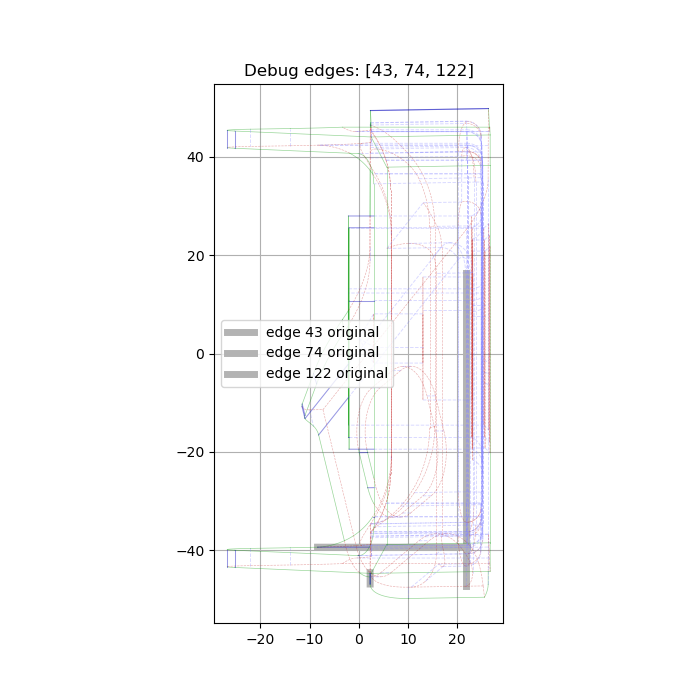

In [92]:
# после debug_edge_segment_coverage увидели, что edge 123 lost
fig, ax = debug_plot_edge_and_segments(side_view_new, [43, 74, 122], edge_segments, projection_new)
plt.show()

# Возвращаем потерянные рёбра

In [100]:
from collections import defaultdict

def build_edge_segments_from_labels_new_schema(
    view: AnalyticView2D,
    labels_per_edge: Dict[int, List[str]],
    *,
    min_run: int = 3,
    fallback_visibility: Optional[Dict[int, str]] = None,
) -> List[DraftEdgeSegment2D]:
    """
    Строит сегменты рёбер по меткам HLR с простым сглаживанием +
    ГАРАНТИРУЕТ, что ни одно ребро не "пропадёт":

      - если по ребру не удалось построить ни одного сегмента,
        создаётся fallback-сегмент на всю длину ребра с исходной
        видимостью (fallback_visibility[e_idx]).

    min_run:
        минимальное количество подряд идущих точек с новым классом,
        чтобы начать новый сегмент. Короткие "островки" считаем шумом.
    """
    segments: List[DraftEdgeSegment2D] = []
    has_segment_for_edge: Dict[int, bool] = defaultdict(bool)

    def label_to_vis_style(lbl: str) -> Optional[Tuple[str, str]]:
        if lbl == "vis":
            return "visible", "solid"
        if lbl == "hid":
            return "hidden", "hidden"
        if lbl == "vis_outline":
            return "silhouette", "solid_thick"
        if lbl == "hid_outline":
            return "hidden", "hidden"
        return None  # 'none' и прочие

    # --- 1. Основная сегментация по HLR-меткам ---
    for e_idx, e in view.edges.items():
        pts = e.points
        if len(pts) < 2:
            continue

        labels = labels_per_edge.get(e_idx)
        if not labels or len(labels) != len(pts):
            continue

        # --- предварительное сглаживание ---
        cleaned = labels.copy()
        n = len(cleaned)

        # 1) 'none' -> соседний класс, если оба соседа совпадают
        for i in range(1, n - 1):
            if cleaned[i] == "none":
                if cleaned[i - 1] == cleaned[i + 1] and cleaned[i - 1] != "none":
                    cleaned[i] = cleaned[i - 1]

        # 2) run-length сглаживание: короткие островки < min_run затираем
        i = 0
        while i < n:
            lbl = cleaned[i]
            j = i + 1
            while j < n and cleaned[j] == lbl:
                j += 1
            run_len = j - i
            if lbl != "none" and run_len < min_run:
                left = cleaned[i - 1] if i - 1 >= 0 else None
                right = cleaned[j] if j < n else None
                if left is not None and left == right and left != "none":
                    for k in range(i, j):
                        cleaned[k] = left
            i = j

        # --- строим сегменты по cleaned ---
        current_lbl = None
        current_vis = None
        current_style = None
        start_idx = 0

        for idx in range(n):
            lbl = cleaned[idx]
            vs = label_to_vis_style(lbl)

            if vs is None:
                # нет валидного класса — закрываем сегмент, если был
                if current_vis is not None and idx - start_idx >= 2:
                    seg_points = pts[start_idx:idx]
                    segments.append(
                        DraftEdgeSegment2D(
                            parent_edge_index=e_idx,
                            points=seg_points,
                            visibility=current_vis,
                            line_style=current_style,
                        )
                    )
                    has_segment_for_edge[e_idx] = True

                current_lbl = None
                current_vis = None
                current_style = None
                start_idx = idx + 1
                continue

            vis, style = vs

            if current_lbl is None:
                current_lbl = lbl
                current_vis = vis
                current_style = style
                start_idx = idx
            elif lbl != current_lbl:
                # смена класса -> закрываем старый сегмент
                if current_vis is not None and idx - start_idx >= 2:
                    seg_points = pts[start_idx:idx]
                    segments.append(
                        DraftEdgeSegment2D(
                            parent_edge_index=e_idx,
                            points=seg_points,
                            visibility=current_vis,
                            line_style=current_style,
                        )
                    )
                    has_segment_for_edge[e_idx] = True

                current_lbl = lbl
                current_vis = vis
                current_style = style
                start_idx = idx

        # хвост
        if current_vis is not None and n - start_idx >= 2:
            seg_points = pts[start_idx:n]
            segments.append(
                DraftEdgeSegment2D(
                    parent_edge_index=e_idx,
                    points=seg_points,
                    visibility=current_vis,
                    line_style=current_style,
                )
            )
            has_segment_for_edge[e_idx] = True

    # --- 2. Fallback: рёбра без сегментов восстанавливаем целиком ---
    for e_idx, e in view.edges.items():
        if has_segment_for_edge[e_idx]:
            continue  # по ребру уже есть сегменты

        if len(e.points) < 2:
            continue

        # 1) пробуем вывести видимость по HLR-меткам для этого ребра
        labels = labels_per_edge.get(e_idx, [])
        hlr_vis = None
        if labels:
            # считаем частоты
            cnt = Counter(labels)
            # убираем явный мусор
            for noise in ("none",):
                cnt.pop(noise, None)

            if cnt:
                # берём наиболее частый HLR-label и маппим в visible/hidden
                hlr_label, _ = cnt.most_common(1)[0]

                # та же функция, что мы уже используем:
                # vis_outline -> 'visible' или 'silhouette' — здесь можно
                # сделать выбор, как тебе удобнее.
                if hlr_label in ("vis", "vis_outline"):
                    hlr_vis = "visible"
                elif hlr_label in ("hid", "hid_outline"):
                    hlr_vis = "hidden"

        # 2) если HLR дал понятный ответ — используем его
        if hlr_vis is not None:
            vis = hlr_vis
        else:
            # 3) иначе откатываемся к старой видимости
            vis = None
            if fallback_visibility is not None:
                vis = fallback_visibility.get(e_idx)

            if vis is None or vis == "unknown":
                vis = "visible"

        # 4) line_style по vis
        if vis == "visible":
            style = "solid"
        elif vis == "hidden":
            style = "hidden"
        elif vis == "silhouette":
            style = "solid_thick"
        else:
            style = "solid"

        seg = DraftEdgeSegment2D(
            parent_edge_index=e_idx,
            points=e.points,
            visibility=vis,
            line_style=style,
        )
        segments.append(seg)

    return segments

In [ ]:
# 1. делаем snapshot старой видимости до HLR-уточнения
old_vis = {idx: e.visibility for idx, e in side_view_new.edges.items()}

In [101]:
# 2. классификация по HLR
labels_per_edge = classify_edge_samples_by_hlr(
    side_view_new,
    projection_new,
    n_samples_hlr=64,
    tol_factor=1e-3,
)

# 3. сегменты с fallback
edge_segments = build_edge_segments_from_labels_new_schema(
    side_view_new,
    labels_per_edge,
    min_run=3,
    fallback_visibility=old_vis,
)

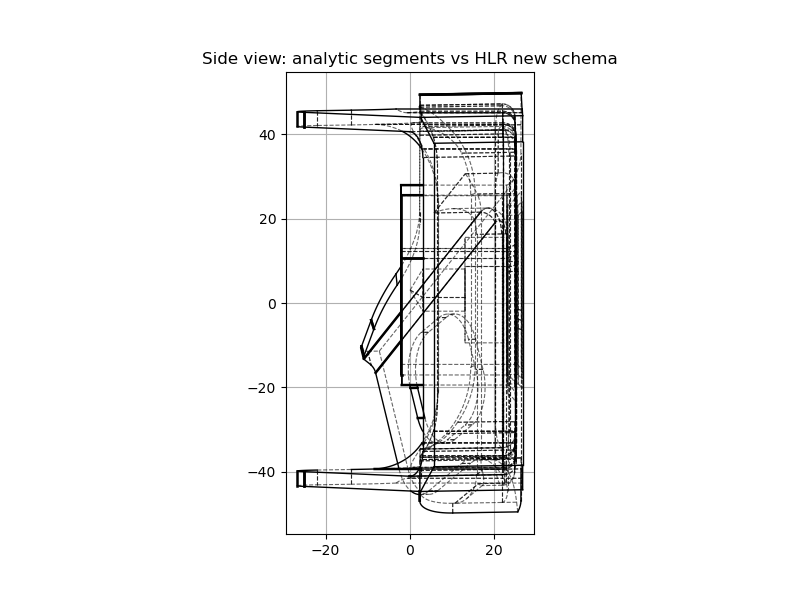

In [102]:
outline_segments = build_outline_segments_from_hlr(projection_new, n_samples=64)
segments = edge_segments + outline_segments

# 4. Смотрим, как это выглядит
fig, ax = draw_edge_segments(segments, title="Side view: analytic segments vs HLR new schema")
plt.show()

In [103]:
# ... refine_analytic_visibility_with_hlr / build_edge_segments_from_labels ...
coverage_info = debug_edge_segment_coverage(side_view_new, edge_segments)
debug_edge_visibility_diff(side_view_new, old_vis, edge_segments)

[DEBUG] Edge coverage by segments:
[DEBUG] Edge visibility diff (old vs segments-derived):
  Edge    1: old=unknown    -> new=hidden     (len=19.5)
  Edge    2: old=unknown    -> new=hidden     (len=2.381)
  Edge    3: old=unknown    -> new=hidden     (len=21.43)
  Edge    4: old=unknown    -> new=hidden     (len=1.965)
  Edge    5: old=unknown    -> new=hidden     (len=2.07)
  Edge    6: old=unknown    -> new=hidden     (len=19.5)
  Edge    7: old=unknown    -> new=hidden     (len=1.914)
  Edge    8: old=unknown    -> new=hidden     (len=19.48)
  Edge    9: old=unknown    -> new=hidden     (len=1.586)
  Edge   10: old=unknown    -> new=hidden     (len=21.43)
  Edge   11: old=unknown    -> new=hidden     (len=2.381)
  Edge   12: old=unknown    -> new=hidden     (len=19.5)
  Edge   13: old=unknown    -> new=hidden     (len=2.07)
  Edge   14: old=unknown    -> new=hidden     (len=1.965)
  Edge   15: old=unknown    -> new=hidden     (len=30.5)
  Edge   16: old=unknown    -> new=hidden    

In [104]:
from collections import Counter

def debug_segment_vs_hlr_confusion(
    segments: List[DraftEdgeSegment2D],
    projection: Dict[str, TopoDS_Shape],
    *,
    n_samples_hlr: int = 64,
    tol_factor: float = 1e-3,
):
    """
    Строит confusion matrix между видимостью наших сегментов и HLR.

    Для каждого сегмента:
      - берём его точки,
      - для каждой точки ищем ближайший HLR-семпл (vis/hid/outline),
      - по большинству для этого сегмента определяем HLR-метку,
      - сравниваем с seg.visibility (visible/hidden/silhouette),
      - накапливаем статистику (по количеству сегментов и по длине).
    """
    hlr_pts = _collect_hlr_samples(projection, n_samples=n_samples_hlr)
    if not hlr_pts:
        print("[SEG HLR CONF] HLR samples are empty — nothing to compare.")
        return

    # Базовый размер сцены (для tol)
    xs = [p[0] for p in hlr_pts]
    ys = [p[1] for p in hlr_pts]
    x_min, x_max = min(xs), max(xs)
    y_min, y_max = min(ys), max(ys)
    diag = math.hypot(x_max - x_min, y_max - y_min) or 1.0
    tol2 = (tol_factor * diag) ** 2

    # Маппинг HLR-лейблов в "грубую" видимость
    def hlr_label_to_vis(lbl: str) -> str:
        if lbl in ("vis", "vis_outline"):
            return "visible"
        if lbl in ("hid", "hid_outline"):
            return "hidden"
        return "unknown"

    # Конфьюжн по количеству сегментов и по длине
    count_conf = Counter()
    length_conf = Counter()

    for seg in segments:
        pts = seg.points
        if len(pts) < 2:
            continue

        # длина сегмента (для веса)
        seg_len = _polyline_length(pts)

        # если длина совсем нулевая — пропускаем
        if seg_len <= 1e-9:
            continue

        # Для каждой точки — ближайший HLR-класс
        hlr_labels = []
        for (x, y) in pts:
            best_lbl = None
            best_d2 = tol2  # дальше этого расстояния не считаем совпадением

            for (hx, hy, hlabel) in hlr_pts:
                dx = x - hx
                dy = y - hy
                d2 = dx * dx + dy * dy
                if d2 < best_d2:
                    best_d2 = d2
                    best_lbl = hlabel

            if best_lbl is None:
                continue
            hlr_labels.append(best_lbl)

        if not hlr_labels:
            hlr_vis = "unknown"
        else:
            # мажоритарный HLR-класс -> грубая видимость
            most_hlr_lbl, _ = Counter(hlr_labels).most_common(1)[0]
            hlr_vis = hlr_label_to_vis(most_hlr_lbl)

        my_vis = seg.visibility or "unknown"

        # накапливаем
        count_conf[(hlr_vis, my_vis)] += 1
        length_conf[(hlr_vis, my_vis)] += seg_len

    # Печать результатов
    print("[SEG HLR CONF] confusion by segment count:")
    for (hlr_vis, my_vis), cnt in sorted(count_conf.items()):
        print(f"  HLR={hlr_vis:10s}  OUR={my_vis:10s} : {cnt:4d} segments")

    print("[SEG HLR CONF] confusion by total length:")
    for (hlr_vis, my_vis), total_len in sorted(length_conf.items()):
        print(f"  HLR={hlr_vis:10s}  OUR={my_vis:10s} : {total_len:8.3f} length")
    

In [105]:
debug_segment_vs_hlr_confusion(edge_segments, projection_new,
                               n_samples_hlr=64, tol_factor=1e-3)

[SEG HLR CONF] confusion by segment count:
  HLR=hidden      OUR=hidden     :  342 segments
  HLR=visible     OUR=silhouette :    6 segments
  HLR=visible     OUR=visible    :   66 segments
[SEG HLR CONF] confusion by total length:
  HLR=hidden      OUR=hidden     : 5234.370 length
  HLR=visible     OUR=silhouette :   39.920 length
  HLR=visible     OUR=visible    : 1101.916 length


# ищем несовпадения

In [ ]:
from typing import Any
def find_mismatched_segments(
    segments: List[DraftEdgeSegment2D],
    projection: Dict[str, TopoDS_Shape],
    *,
    n_samples_hlr: int = 64,
    tol_factor: float = 1e-3,
    include_silhouette: bool = False,
) -> List[Dict[str, Any]]:
    """
    Находит сегменты, у которых видимость по HLR не совпадает
    с нашей (seg.visibility).

    Возвращает список словарей:
      {
        'seg_idx': int,             # индекс сегмента в исходном списке
        'parent_edge_index': int,   # исходное ребро
        'seg_len': float,           # длина сегмента
        'our_vis': str,             # seg.visibility
        'hlr_vis': str,             # 'visible' / 'hidden' / 'unknown'
      }

    include_silhouette:
      - если False: silhouette считаем эквивалентом 'visible' (OUR=visible)
        и ищем только реально конфликтные случаи visible↔hidden;
      - если True: silhouette считаем отдельным классом и ловим
        расхождения вида 'HLR=visible OUR=silhouette' и т.п.
    """
    hlr_pts = _collect_hlr_samples(projection, n_samples=n_samples_hlr)
    mismatches: List[Dict[str, Any]] = []

    if not hlr_pts:
        print("[SEG MISMATCH] HLR samples are empty.")
        return mismatches

    # базовый масштаб
    xs = [p[0] for p in hlr_pts]
    ys = [p[1] for p in hlr_pts]
    x_min, x_max = min(xs), max(xs)
    y_min, y_max = min(ys), max(ys)
    diag = math.hypot(x_max - x_min, y_max - y_min) or 1.0
    tol2 = (tol_factor * diag) ** 2

    def hlr_label_to_vis(lbl: str) -> str:
        if lbl in ("vis", "vis_outline"):
            return "visible"
        if lbl in ("hid", "hid_outline"):
            return "hidden"
        return "unknown"

    for seg_idx, seg in enumerate(segments):
        pts = seg.points
        if len(pts) < 2:
            continue

        seg_len = _polyline_length(pts)
        if seg_len <= 1e-9:
            continue

        # собираем HLR-лейблы по точкам сегмента
        hlr_labels = []
        for (x, y) in pts:
            best_lbl = None
            best_d2 = tol2

            for (hx, hy, hlabel) in hlr_pts:
                dx = x - hx
                dy = y - hy
                d2 = dx * dx + dy * dy
                if d2 < best_d2:
                    best_d2 = d2
                    best_lbl = hlabel

            if best_lbl is not None:
                hlr_labels.append(best_lbl)

        if not hlr_labels:
            hlr_vis = "unknown"
        else:
            most_lbl, _ = Counter(hlr_labels).most_common(1)[0]
            hlr_vis = hlr_label_to_vis(most_lbl)

        # наша видимость
        our_vis = seg.visibility or "unknown"

        # при желании «сворачиваем» silhouette в visible
        if not include_silhouette:
            if our_vis == "silhouette":
                our_vis_cmp = "visible"
            else:
                our_vis_cmp = our_vis
        else:
            our_vis_cmp = our_vis

        # нас интересуют конфликты visible↔hidden
        if hlr_vis in ("visible", "hidden") and our_vis_cmp in ("visible", "hidden"):
            if hlr_vis != our_vis_cmp:
                mismatches.append(
                    {
                        "seg_idx": seg_idx,
                        "parent_edge_index": seg.parent_edge_index,
                        "seg_len": seg_len,
                        "our_vis": our_vis,
                        "hlr_vis": hlr_vis,
                    }
                )

    # сортируем по длине, чтобы сначала смотреть самые «важные» ошибки
    mismatches.sort(key=lambda d: d["seg_len"], reverse=True)

    print("[SEG MISMATCH] total mismatches:", len(mismatches))
    for m in mismatches[:20]:
        print(
            f"  seg_idx={m['seg_idx']:4d}, edge={m['parent_edge_index']:4d}, "
            f"len={m['seg_len']:7.3f}, HLR={m['hlr_vis']:8s}, OUR={m['our_vis']:10s}"
        )

    return mismatches

In [107]:
mismatches = find_mismatched_segments(
    edge_segments,
    projection_new,
    n_samples_hlr=64,
    tol_factor=1e-3,
    include_silhouette=False,  # пока ищем только hidden↔visible
)

[SEG MISMATCH] total mismatches: 0


In [108]:
def debug_plot_single_segment(
    view: AnalyticView2D,
    seg: DraftEdgeSegment2D,
    projection: Optional[Dict[str, TopoDS_Shape]] = None,
):
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.set_aspect("equal", "box")

    # исходное ребро серым
    e = view.edges.get(seg.parent_edge_index)
    if e is not None and len(e.points) >= 2:
        xs = [p[0] for p in e.points]
        ys = [p[1] for p in e.points]
        ax.plot(xs, ys, "-", color="0.8", linewidth=1.0, label="edge")

    # сам сегмент жирно
    pts = seg.points
    sx = [p[0] for p in pts]
    sy = [p[1] for p in pts]

    if seg.visibility == "visible":
        ls, lw = "-", 2.0
    elif seg.visibility == "hidden":
        ls, lw = "--", 1.5
    elif seg.visibility == "silhouette":
        ls, lw = "-", 2.5
    else:
        ls, lw = "-", 1.5

    ax.plot(sx, sy, ls, color="black", linewidth=lw, label=f"seg ({seg.visibility})")

    # HLR сверху (опционально)
    if projection is not None:
        draw_hlr_compound_by_type(
            projection,
            ax,
            linewidth=0.5,
            alpha=0.5,
        )

    ax.grid(True)
    ax.legend()
    return fig, ax


In [109]:
def find_suspicious_hidden_segments(
    segments: List[DraftEdgeSegment2D],
    projection: Dict[str, TopoDS_Shape],
    *,
    n_samples_hlr: int = 64,
    tol_factor: float = 1e-3,
    min_visible_frac: float = 0.1,
) -> List[Dict[str, Any]]:
    """
    Ищем сегменты с visibility='hidden', у которых
    заметная доля точек по HLR на самом деле попадает
    на видимые линии.

    min_visible_frac:
        минимальная доля "видимых" HLR-точек (0..1),
        чтобы считать сегмент подозрительным.
    """
    hlr_pts = _collect_hlr_samples(projection, n_samples=n_samples_hlr)
    suspicious: List[Dict[str, Any]] = []

    if not hlr_pts:
        print("[SUSP HIDDEN] HLR samples empty.")
        return suspicious

    # масштаб
    xs = [p[0] for p in hlr_pts]
    ys = [p[1] for p in hlr_pts]
    x_min, x_max = min(xs), max(xs)
    y_min, y_max = min(ys), max(ys)
    diag = math.hypot(x_max - x_min, y_max - y_min) or 1.0
    tol2 = (tol_factor * diag) ** 2

    def is_visible_hlr(lbl: str) -> bool:
        return lbl in ("vis", "vis_outline")

    for seg_idx, seg in enumerate(segments):
        if seg.visibility != "hidden":
            continue

        pts = seg.points
        if len(pts) < 2:
            continue

        seg_len = _polyline_length(pts)
        if seg_len <= 1e-9:
            continue

        n_total = 0
        n_vis = 0

        for (x, y) in pts:
            best_lbl = None
            best_d2 = tol2
            for (hx, hy, hlabel) in hlr_pts:
                dx = x - hx
                dy = y - hy
                d2 = dx * dx + dy * dy
                if d2 < best_d2:
                    best_d2 = d2
                    best_lbl = hlabel

            if best_lbl is None:
                continue

            n_total += 1
            if is_visible_hlr(best_lbl):
                n_vis += 1

        if n_total == 0:
            continue

        frac_vis = n_vis / n_total

        if frac_vis >= min_visible_frac:
            suspicious.append(
                {
                    "seg_idx": seg_idx,
                    "parent_edge_index": seg.parent_edge_index,
                    "seg_len": seg_len,
                    "visible_frac": frac_vis,
                }
            )

    suspicious.sort(key=lambda d: d["visible_frac"], reverse=True)

    print(f"[SUSP HIDDEN] total suspicious segments: {len(suspicious)}")
    for m in suspicious[:20]:
        print(
            f"  seg_idx={m['seg_idx']:4d}, edge={m['parent_edge_index']:4d}, "
            f"len={m['seg_len']:7.3f}, visible_frac={m['visible_frac']:.3f}"
        )

    return suspicious


In [110]:
susp = find_suspicious_hidden_segments(
    edge_segments,
    projection_new,
    n_samples_hlr=64,
    tol_factor=1e-3,
    min_visible_frac=0.1,      # можно поджать/поднять
)


[SUSP HIDDEN] total suspicious segments: 6
  seg_idx= 397, edge= 151, len=  1.395, visible_frac=0.500
  seg_idx= 400, edge= 160, len=  3.844, visible_frac=0.500
  seg_idx= 403, edge= 199, len=  3.389, visible_frac=0.500
  seg_idx= 408, edge= 246, len= 19.296, visible_frac=0.500
  seg_idx= 409, edge= 248, len= 19.296, visible_frac=0.500
  seg_idx= 410, edge= 367, len=  1.698, visible_frac=0.500


{'seg_idx': 410, 'parent_edge_index': 367, 'seg_len': 1.6981348681323796, 'visible_frac': 0.5}


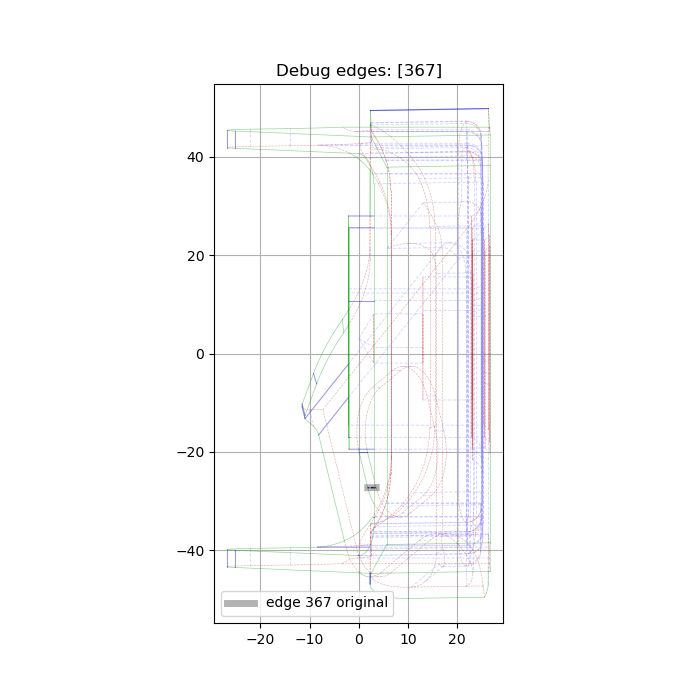

In [117]:
bad = susp[5]   # или найти глазами нужный edge/len
seg_idx = bad["seg_idx"]
edge_idx = bad["parent_edge_index"]

print(bad)

# 1) контекст — всё ребро + все его сегменты + HLR
fig, ax = debug_plot_edge_and_segments(
    side_view_new,
    edge_indices=edge_idx,
    segments=edge_segments,
    projection=projection_new,
)
plt.show()

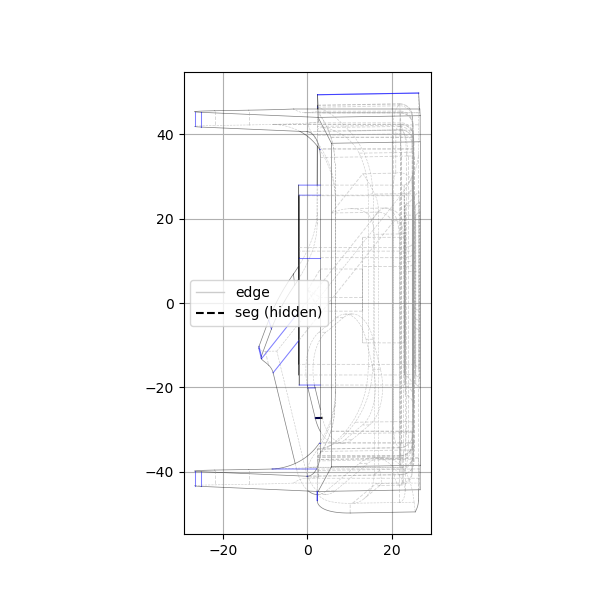

In [118]:
# 2) прицельно один сегмент (если нужно)
bad_seg = edge_segments[seg_idx]
fig, ax = debug_plot_single_segment(
    side_view_new,
    bad_seg,
    projection_new,
)
plt.show()